# Prerequisites

In [2]:
!pip install torchdyn

In [3]:
# Definitions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

from matplotlib.animation import FuncAnimation

def animate_dynamic_point(trajectory, resolution_Hz=15, duration=None, fig_size=8):
    plt.ioff()
    trajectory = np.array(trajectory)
    trajectory = trajectory.T[0:2].T
    if len(trajectory.shape) == 1:
        trajectory = trajectory.reshape(trajectory.size, 1)
    if trajectory.shape == (trajectory.size, 1):
        trajectory = np.stack((trajectory.T[0], np.zeros(trajectory.size))).T
    if duration == None:
        frames = range(trajectory.shape[0])
    else:
        frames = range(int(duration * resolution_Hz))
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    # set the axes limits
    ax.axis([-2,2,-2, 2])
    ax.set_aspect("equal")
    # create a point in the axes
    plt.grid()
    ax.plot(0, 0, markersize=215, marker="o", color = 'black')
    ax.plot(0, -1.5, markersize=108, marker="o", color = 'red')
    plt.text(0, 0, 'Obstacle', horizontalalignment='center', verticalalignment='center', color='white')
    plt.text(0, -1.5, 'Target', horizontalalignment='center', verticalalignment='center', color='white')
    point, = ax.plot(0,1, marker="o")

    # Updating function, to be repeatedly called by the animation
    def update(t):
        # obtain point coordinates
        x,y = trajectory[int(t) % trajectory.shape[0]]
        # set point's coordinates
        point.set_data([x],[y])
        return point,


    ani = FuncAnimation(fig, update, interval=1000/resolution_Hz, blit=True, repeat=True,
                    frames=frames)
    plt.ion()
    return ani

In [4]:
from scipy.linalg import norm
import torch

class ParametrizedDiscreteTimeSystem:
    def __init__(self,
                 state_transition_function,  # f(., .)
                 initial_state,              # x_0
                 discount
                 ):
      self.__state_transition_function = state_transition_function
      self.__initial_state = initial_state
      self.__discount = discount

    def run_with_feedback_controller(self,
                                     feedback_controller,
                                     initial_state=None,
                                     steps=100):
      initial_state = initial_state if initial_state else self.__initial_state
      trajectory = [initial_state]
      actions = []
      total_reward = 0
      accumulated_discount = 1
      for _ in range(steps):
        current_state = trajectory[-1]
        control_input = feedback_controller(current_state)
        actions.append(control_input)
        try:
            next_state, reward = self.__state_transition_function(current_state, control_input)
            total_reward += reward * accumulated_discount
            accumulated_discount *= self.__discount
        except OverflowError:
            print("The trajectory blew up. Ending the episode prematurely.")
            return np.array(trajectory), np.array(actions), total_reward
        trajectory.append(next_state)
      return np.array([x.detach().cpu().numpy() for x in trajectory]), np.array([x.detach().cpu().numpy() for x in actions]), total_reward

In [5]:
import torch

torch.cuda.is_available()

True

# Driving a dynamic body

$$
\begin{aligned}
&\begin{cases}
 \frac{\partial}{\partial t}x(t) = \begin{cases}v(t), \text{ if } 2.4 \geq \lVert x(t)\rVert_2 \geq 1 \text{ or } v^T(t)x(t) > 0\\ 0.5 (I - 1.1x(t)x^T(t))v(t), \text{ otherwise}\end{cases}\\
 \frac{\partial}{\partial t}v(t) =  u(t)\end{cases}\\
& x_0 = \left(0 \atop 1.5 \right) \\
& v_0 = \left(0 \atop 0 \right) \\
& u(t) = \rho_\theta\big(x(t \text{ mod } 1)\big), \\
& r(x(t), v(t), u(t)) := -\lVert x(t) - \left(0\atop -1.5\right) \rVert_2^2, \ \gamma = 0.98
\end{aligned}
$$


## Discretization

$$
\begin{aligned}
& \left(x_{t + 1} \atop v_{t + 1}\right) = f(x_t, v_t, u_t)\\
& x_0 = \left(0 \atop 1.5 \right) \\
& v_0 = \left(0 \atop 0 \right) \\
& u_t = \rho_\theta(x_t), \\
& r_t := -\int_t^{t + 1}\gamma^{\tau - t}\lVert x(\tau ) - \left(0\atop -1.5\right) \rVert_2^2\text{d} \tau, \ \gamma = 0.98
\end{aligned}
$$

Here $f(\cdot, \cdot, \cdot) := x(t), v(t), u(t) \longmapsto x(t + 1), v(t + 1)$.


**Useful resources**:
* [torchdyn](https://torchdyn.readthedocs.io/en/latest/tutorials/quickstart.html)

In [6]:
from scipy.integrate import quad, solve_ivp
from torchdyn.core import NeuralODE


device = torch.device("cuda")



dynamic_point_initial_state = torch.Tensor([0, 1.5, 0.14, 0.0])


try:
    dynamic_point_initial_state = dynamic_point_initial_state.to(device)
except:
    print("Failed to initialize a CUDA device. Using CPU.")
    device = torch.device("cpu")
    dynamic_point_initial_state = dynamic_point_initial_state.to(device)
dynamic_point_discount = 0.98


class DynamicPointDynamics(torch.nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()

    def forward(self, state_reward_action_time):
        position = state_reward_action_time[:, 0:2]
        speed = state_reward_action_time[:, 2:4]
        reward = state_reward_action_time[:, 4:5]
        action = state_reward_action_time[:, 5:7]
        time = state_reward_action_time[:, 7:]
        drift = torch.index_select(state_reward_action_time, 1, torch.LongTensor([2, 3, 0, 1, 4, 5, 6, 7]).to(device))
        drift_position = drift[:, 0:2]
        drift_speed = drift[:, 2:4]
        drift_reward = drift[:, 4:5]
        drift_action = drift[:, 5:7]
        drift_time = drift[:, 7:]
        drift_time *= 0
        drift_time += 1
        radius_squared = torch.matmul(position.reshape(position.shape[0], 1, position.shape[1]),
                                      position.reshape(position.shape[0], position.shape[1], 1)).squeeze(1)
        radial_velocity = torch.matmul(position.reshape(position.shape[0], 1, position.shape[1]),
                                       speed.reshape(speed.shape[0], speed.shape[1], 1)).squeeze(1)
        drift_position -= 1.0 * (~((radius_squared >= 1) * (radius_squared <= (2.4 ** 2)))) * (radial_velocity < 0) * (radial_velocity / radius_squared) * position
        drift_position *= 1 - 0.5 * (~((radius_squared >= 1) * (radius_squared <= (2.4 ** 2))))
        drift_action *= 0
        drift_speed *= 0
        drift_speed += action - (1/2) * speed
        drift_reward *= 0
        direction = position - torch.tensor([0, -1.5]).to(device)
        distance_squared = torch.matmul(direction.reshape(speed.shape[0], 1, direction.shape[1]),
                                        direction.reshape(speed.shape[0], direction.shape[1], 1)).squeeze(1)
        drift_reward += -(dynamic_point_discount ** time) * distance_squared
        return drift


class DynamicPointTransition(torch.nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.ode = NeuralODE(DynamicPointDynamics(),  solver='dopri5').to(device)

    def forward(self, state_action):
        state_reward_action_time = torch.index_select(state_action, 1, torch.LongTensor([0, 1, 2, 3, 3, 4, 5, 5]).to(device))
        state_reward_action_time[:, 4:5] *= 0
        state_reward_action_time[:, 7:]  *= 0
        state_reward_action_time = self.ode(state_reward_action_time, torch.linspace(0, 1, 2).to(device))[1][-1]
        state_reward = state_reward_action_time[:, :5]
        return state_reward


dynamic_point_transition = DynamicPointTransition()

def dynamic_point_transition_function(state, control):
    state_reward = dynamic_point_transition(torch.cat((state[None], control[None]), 1).to(device))[0]
    return state_reward[:-1], state_reward[-1]


dynamic_point_system = ParametrizedDiscreteTimeSystem(dynamic_point_transition_function,
                                                      dynamic_point_initial_state,
                                                      dynamic_point_discount)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field does not have `nn.Parameters` to optimize.


# Problem 2: Optimizing the total cost using Actor-Critic

Useful links:
* [N-step temporal difference](https://towardsdatascience.com/introduction-to-reinforcement-learning-rl-part-7-n-step-bootstrapping-6c3006a13265)
* [ReLU and "dead neurons"](https://towardsdatascience.com/neural-network-the-dead-neuron-eaa92e575748)
* [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

## Dos and don'ts
DO:
* Use CUDA
* Track your metrics
* Make sure your critic converges
* Try architectures of different complexities
* Try different batch sizes
* Use gradient clipping if necessary
* Take a closer look at N-step temporal difference
* If your critic explodes, try changing the batch size or the critic's complexity.

DON'T:
* Run too many epochs. You only have a limited ammount of time.
* Make your architectures too bulky. You have limited computational resources.
* Use an inadequate final activation function for the actor.


### Solution

#### Learners and learning procedures
Define your actor and your critic and implement the relevant updates.

In [10]:
from tqdm import tqdm


torch.manual_seed(0)

torch.backends.cudnn.deterministic=True


class Scale(torch.nn.Module):
    def __init__(self, factor):
        super(self.__class__, self).__init__()
        self.factor = factor

    def forward(self, input):
        return input * self.factor

class Head(torch.nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()

    def forward(self, input):
        norm = torch.matmul(input.reshape(input.shape[0], 1, input.shape[1]),
                            input.reshape(input.shape[0], input.shape[1], 1)).squeeze(1) ** 0.5
        return input * (torch.nn.functional.tanh(norm) / norm)

actor_layer_size = 128
actor = torch.nn.Sequential(
    torch.nn.Linear(4, actor_layer_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(actor_layer_size, actor_layer_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(actor_layer_size, actor_layer_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(actor_layer_size, actor_layer_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(actor_layer_size, actor_layer_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(actor_layer_size, 2),
    Head(),
    Scale(.1)
).to(device)

critic_layer_size = 128
critic = torch.nn.Sequential(
    torch.nn.Linear(4, critic_layer_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(critic_layer_size, critic_layer_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(critic_layer_size, critic_layer_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(critic_layer_size, critic_layer_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(critic_layer_size, critic_layer_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(critic_layer_size, 1),
    torch.nn.Tanh(),
    Scale(100),
).to(device)


class CriticTD(torch.nn.Module):
    def __init__(self, actor, critic):
        super(self.__class__, self).__init__()
        self.critic = critic
        self.actor = actor
        self.transition = DynamicPointTransition()
        self.loss = torch.nn.MSELoss()

    def forward(self, state):
        ## YOUR CODE HERE

        value = self.critic(state)
        with torch.no_grad():
            action = self.actor(state)
            state_reward = self.transition(torch.cat((state, action), dim=1).to(device))[0]
            next_state, reward = state_reward[:-1], state_reward[-1]
            target = reward + dynamic_point_discount*self.critic(next_state)
        temporal_difference_loss = self.loss(value, target)
        return temporal_difference_loss

    def parameters(self):
        return self.critic.parameters()

class ActorImprovedValue(torch.nn.Module):
    def __init__(self, actor, critic):
        super(self.__class__, self).__init__()
        self.critic = critic
        self.actor = actor
        self.transition = DynamicPointTransition()

    def forward(self, state):
      ## YOUR CODE HERE
        action = self.actor(state)
        state_reward = self.transition(torch.cat((state, action), dim=1).to(device))[0]
        next_state, reward = state_reward[:-1], state_reward[-1]
        discounted_next_reward = dynamic_point_discount * self.critic(next_state)
        improved_value = reward + discounted_next_reward

        return -improved_value.mean()

    def parameters(self):
        return self.actor.parameters()



critic_temporal_difference = CriticTD(actor, critic)
actor_improved_value = ActorImprovedValue(actor, critic)

optimizer_critic_kind = torch.optim.Adam ## Change to whichever optimizer you prefer
optimizer_critic_parameters = {
    "lr" : 1e-3,           ## tune
    "weight_decay" : 0.0    ## tune
}
optimizer_critic = optimizer_critic_kind(critic_temporal_difference.parameters(), **optimizer_critic_parameters)



optimizer_actor_kind = torch.optim.Adam ## Change to whichever optimizer you prefer
optimizer_actor_parameters = {
    "lr" : 1e-3,          ## tune
    "weight_decay" : 0.0   ## tune
}
optimizer_actor = optimizer_actor_kind(actor_improved_value.parameters(), **optimizer_actor_parameters)





Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field does not have `nn.Parameters` to optimize.
Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field does not have `nn.Parameters` to optimize.


#### Metrics and visualizers
These are provided for your convenience. No alterations are necessary.

In [11]:
def running_median(x,N):
    idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
    b = [row[row>0] for row in x[idx]]
    return np.array(list(map(np.median,b)))


def critic_relative_error(state):
    system = ParametrizedDiscreteTimeSystem(dynamic_point_transition_function,
                                            state,
                                            dynamic_point_discount)
    with torch.no_grad():
        trajectory, actions, total_reward = dynamic_point_system.run_with_feedback_controller(lambda state: actor(state[None])[0], steps=100)
    return (torch.abs(critic(state[None])[0][0] - total_reward) / total_reward).detach().cpu().numpy()


def plot_actor_and_critic_at_zero_velocity():
    x, y = np.meshgrid(np.linspace(-2,2,10),np.linspace(-2,2,10))
    input = np.stack((x, y, np.zeros(x.shape), np.zeros(x.shape)), axis=2)
    with torch.no_grad():
        actor_output = np.array([actor(torch.tensor(row).float().to(device)).detach().cpu().numpy() for row in input])
        critic_output = np.array([critic(torch.tensor(row).float().to(device)).detach().cpu().numpy() for row in input])[:, :, 0]
    plt.imshow(critic_output[::-1], extent=[-2, 2, -2, 2])
    plt.colorbar()
    plt.quiver(x, y, actor_output[:, :, 0], actor_output[:, :, 1])
    plt.title('Actor and Critic at Zero Velocity')
    plt.show()

def display_critic_relative_error():
    scales = torch.tensor([2.5, 2.5, 0.15, 0.15])
    X = (torch.rand((5, 4)) * scales * 2 - scales).to(device)
    print("Critic relative error:", np.mean([critic_relative_error(state) for state in X]))

def plot_critic_epoch(values):
    plt.plot(running_median(values, 100))
    plt.title('Critic Epoch')
    plt.show()





#### Run your epochs
Tune iterations, batch sizes and epochs.

Critic epoch: 100%|██████████| 1000/1000 [00:26<00:00, 37.31it/s]


Critic mean loss: 43.88451 [39.106220 --> 46.604969]
Critic relative error: -0.7971796


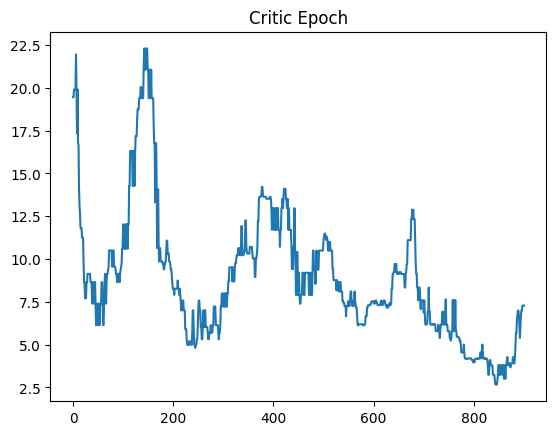


Actor epoch: 100%|██████████| 500/500 [00:31<00:00, 15.63it/s]


Actor mean value: 104.069626 [103.645973 --> 103.840927]


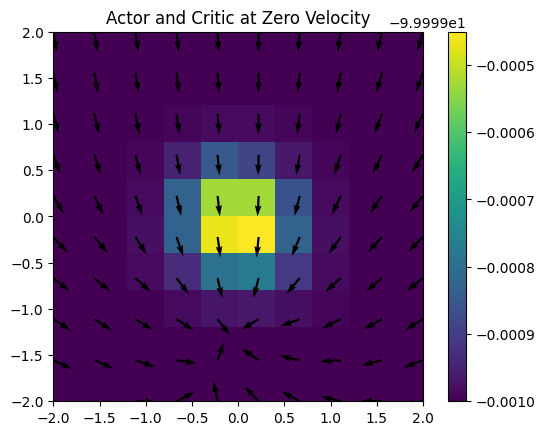

Critic epoch: 100%|██████████| 1000/1000 [00:27<00:00, 36.44it/s]


Critic mean loss: 42.659252 [45.418678 --> 21.775122]
Critic relative error: -0.24290176


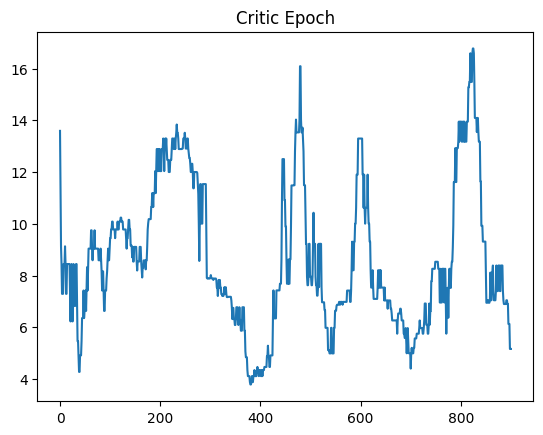


Actor epoch: 100%|██████████| 500/500 [00:31<00:00, 15.68it/s]


Actor mean value: 104.91364 [104.499146 --> 105.690796]


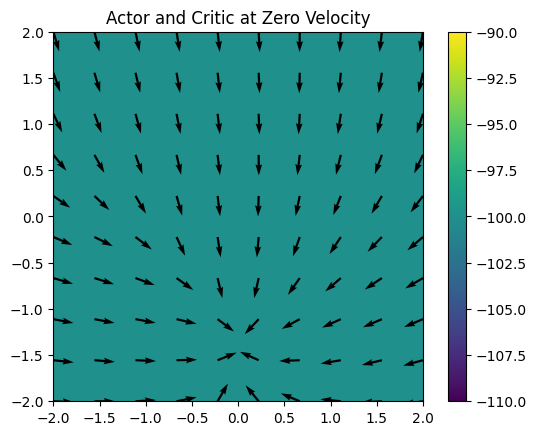

Critic epoch: 100%|██████████| 1000/1000 [00:27<00:00, 35.87it/s]


Critic mean loss: 43.702724 [28.092625 --> 27.183783]
Critic relative error: -0.18945295


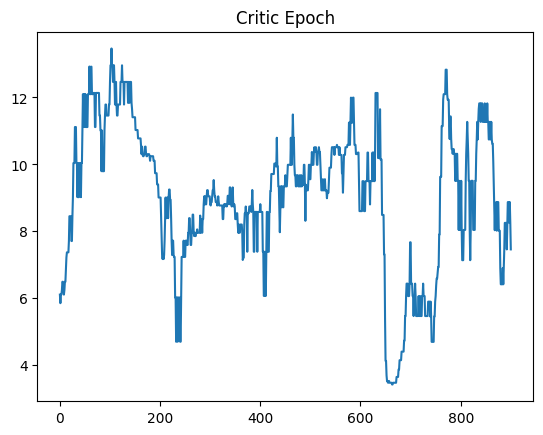


Actor epoch: 100%|██████████| 500/500 [00:32<00:00, 15.44it/s]


Actor mean value: 103.97768 [105.675743 --> 103.059334]


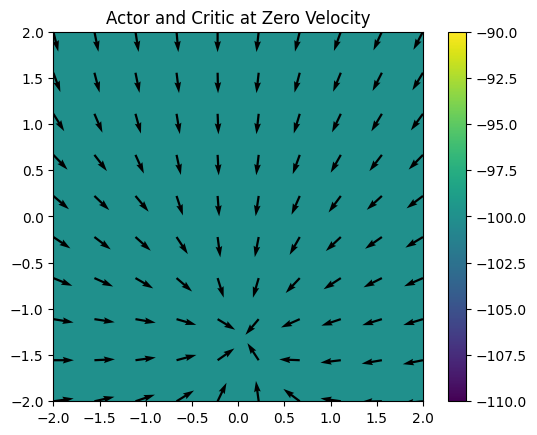

Critic epoch: 100%|██████████| 1000/1000 [00:28<00:00, 34.91it/s]


Critic mean loss: 43.805275 [26.564432 --> 38.393650]
Critic relative error: -0.3966442


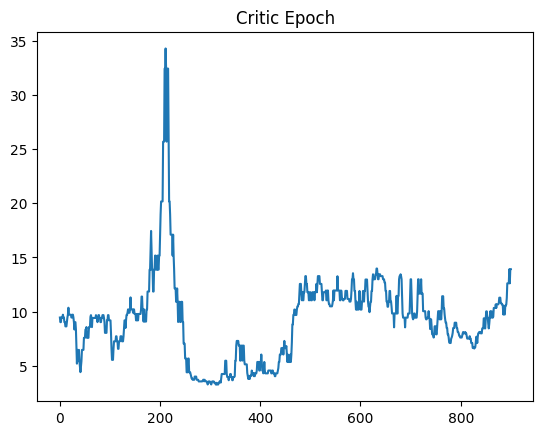


Actor epoch: 100%|██████████| 500/500 [00:33<00:00, 14.75it/s]


Actor mean value: 104.21239 [103.462013 --> 103.646393]


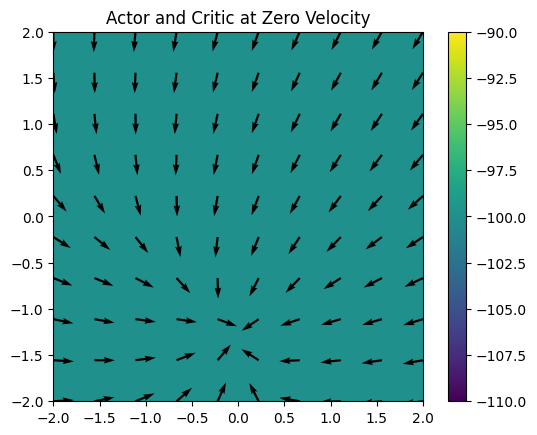

Critic epoch: 100%|██████████| 1000/1000 [00:29<00:00, 33.54it/s]


Critic mean loss: 41.68317 [5.532987 --> 63.669834]
Critic relative error: -0.35487422


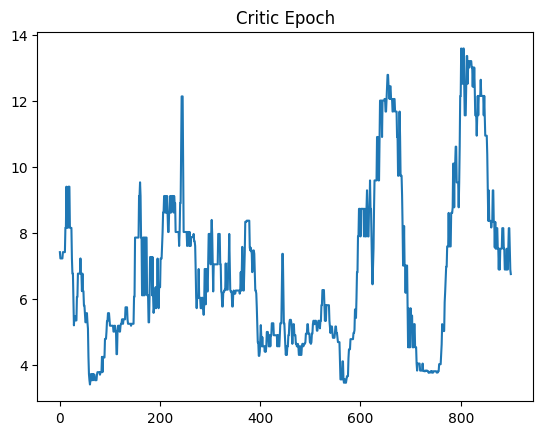


Actor epoch: 100%|██████████| 500/500 [00:34<00:00, 14.69it/s]


Actor mean value: 104.29673 [104.548660 --> 104.129883]


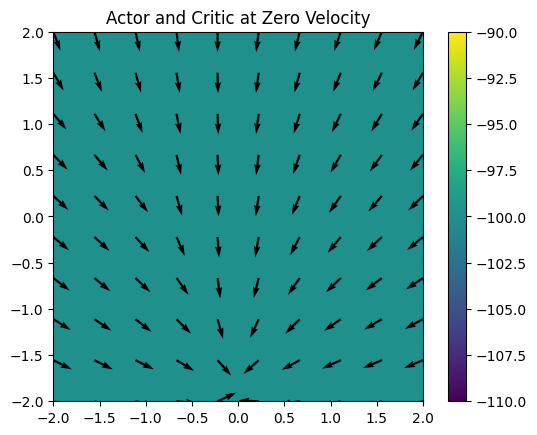

Critic epoch: 100%|██████████| 1000/1000 [00:29<00:00, 33.62it/s]


Critic mean loss: 42.95074 [23.574764 --> 20.902275]
Critic relative error: -0.41603047


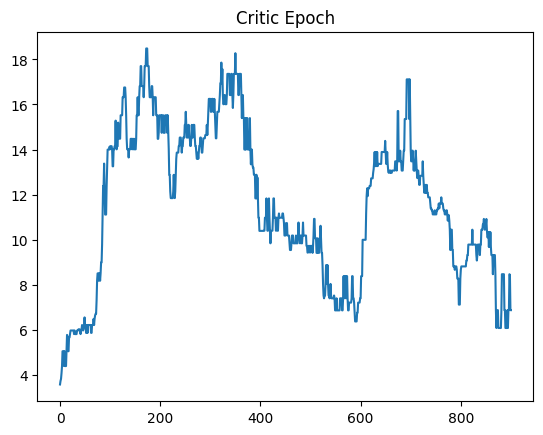


Actor epoch: 100%|██████████| 500/500 [00:34<00:00, 14.64it/s]


Actor mean value: 104.153175 [104.718124 --> 106.097534]


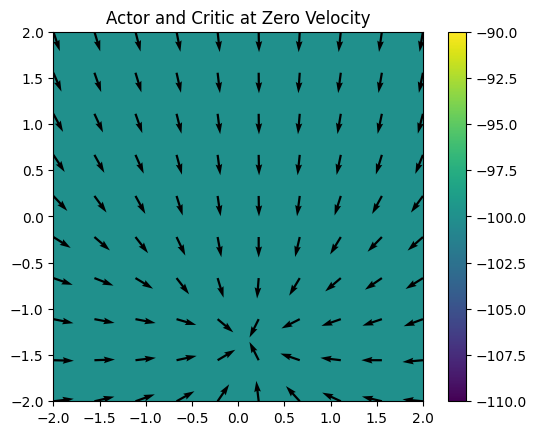

Critic epoch: 100%|██████████| 1000/1000 [00:31<00:00, 32.15it/s]


Critic mean loss: 44.340054 [17.765785 --> 44.345688]
Critic relative error: -0.19498318


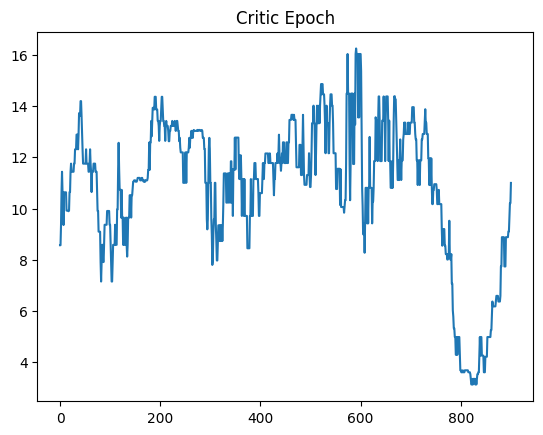


Actor epoch: 100%|██████████| 500/500 [00:34<00:00, 14.49it/s]


Actor mean value: 104.43369 [105.438309 --> 106.213791]


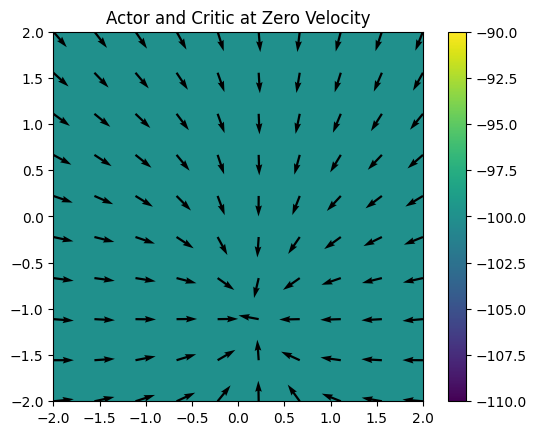

Critic epoch: 100%|██████████| 1000/1000 [00:28<00:00, 35.21it/s]


Critic mean loss: 44.29821 [83.115425 --> 7.328180]
Critic relative error: -0.25787842


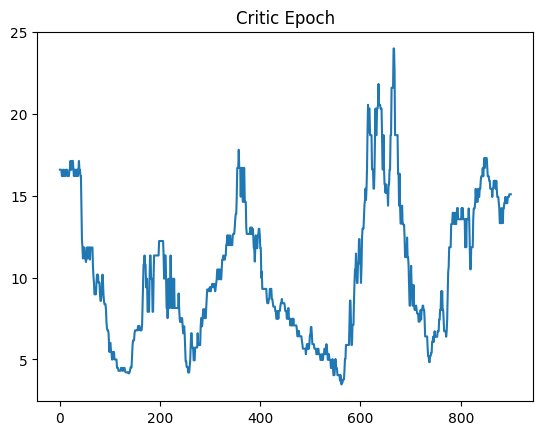


Actor epoch: 100%|██████████| 500/500 [00:33<00:00, 14.75it/s]


Actor mean value: 104.12806 [105.701515 --> 108.011887]


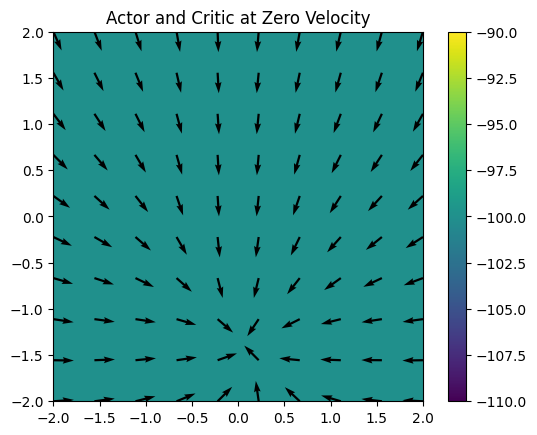

Critic epoch: 100%|██████████| 1000/1000 [00:28<00:00, 34.94it/s]


Critic mean loss: 43.735046 [59.859322 --> 10.015373]
Critic relative error: -0.33702213


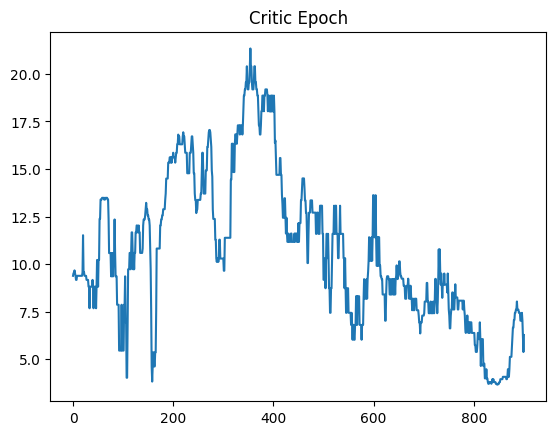


Actor epoch: 100%|██████████| 500/500 [00:35<00:00, 14.23it/s]


Actor mean value: 104.47782 [105.406883 --> 105.659111]


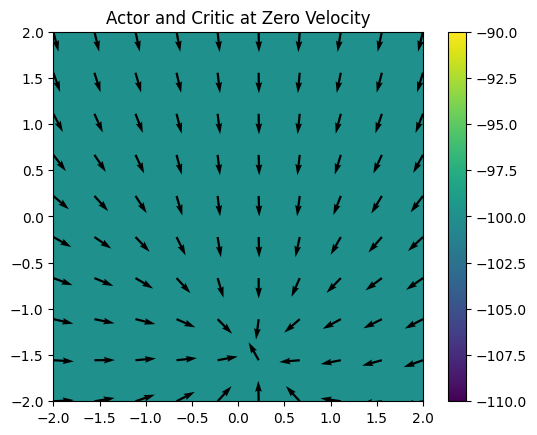

Critic epoch: 100%|██████████| 1000/1000 [00:28<00:00, 34.64it/s]


Critic mean loss: 43.495712 [35.768200 --> 11.245929]
Critic relative error: -0.19350839


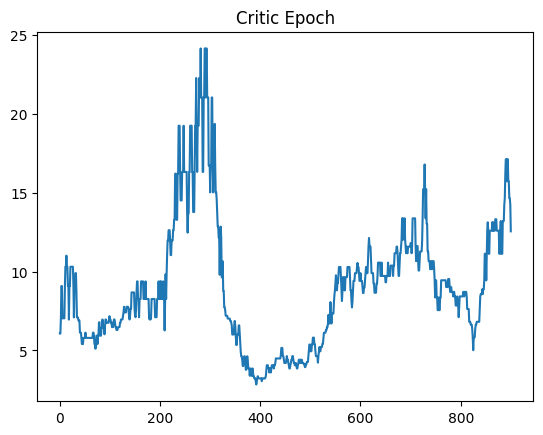


Actor epoch: 100%|██████████| 500/500 [00:40<00:00, 12.38it/s]


Actor mean value: 104.29542 [104.137817 --> 101.456696]


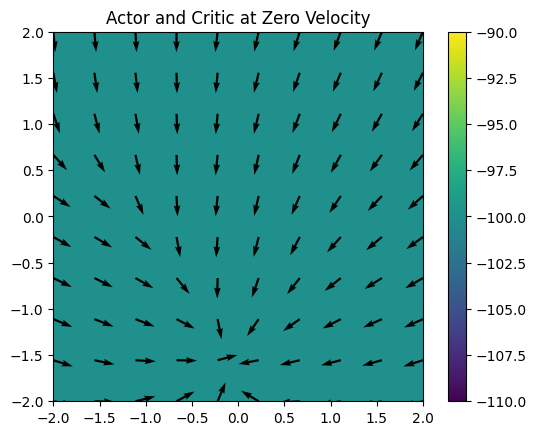

Actor-Critic learning: 100%|██████████| 10/10 [12:05<00:00, 72.53s/it]


In [12]:
def critic_epoch(optimizer, model, iterations, batch_size):
    losses = []
    for iteration in tqdm(range(iterations), "Critic epoch"):
        scales = torch.tensor([2.5, 2.5, 0.15, 0.15])
        X = (torch.rand((batch_size, 4)) * scales * 2 - scales).to(device)
        optimizer.zero_grad()
        loss = model(X)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    print("Critic mean loss:", np.mean(losses), "[%f --> %f]" % (np.mean(losses[0:10]), np.mean(losses[-10:-1])))
    return losses


def actor_epoch(optimizer, model, iterations, batch_size):
    values = []
    for iteration in tqdm(range(iterations), "Actor epoch"):
        scales = torch.tensor([2.5, 2.5, 0.15, 0.15])
        X = (torch.rand((batch_size, 4)) * scales * 2 - scales).to(device)
        optimizer.zero_grad()
        improved_value = model(X)
        improved_value.backward()
        optimizer.step()
        values.append(improved_value.detach().cpu().numpy())
    print("Actor mean value:", np.mean(values), "[%f --> %f]" % (np.mean(values[0:10]), np.mean(values[-10:-1])))
    return values


critic_iterations = 1000
critic_batch_size = 100

actor_iterations = 500
actor_batch_size = 100

epochs = 10
plt.close()
for _ in tqdm(range(epochs), "Actor-Critic learning"):
    optimizer_critic = optimizer_critic_kind(critic_temporal_difference.parameters(), **optimizer_critic_parameters) ## It is important to reinitialize the critic optimizer to erase irrelevant momenta and adaptations
    values = np.array(critic_epoch(optimizer_critic,
                                   critic_temporal_difference,
                                   critic_iterations,
                                   actor_batch_size))
    display_critic_relative_error()
    plot_critic_epoch(values)
    actor_epoch(optimizer_actor,
                actor_improved_value,
                actor_iterations,
                actor_batch_size)
    plot_actor_and_critic_at_zero_velocity()

#### Visualize the outcome

In [13]:
with torch.no_grad():
    trajectory, actions, total_reward = dynamic_point_system.run_with_feedback_controller(lambda state: actor(state[None])[0], steps=100)

animate_dynamic_point(trajectory[::3])